<h1 align="center"><span style='font-family:Georgia'>TABLE OF CONTENTS </span></h1>

_________________________________________________

* [SETUP](#0.0)
* [PROBLEM STATEMNT](#1.0)
* [DATASET](#2.0)
* [SPERATE THE TESTING SET](#3.0)
    - [Splitting manualy](#3.1)
    - [Splitting using StratifiedShuffleSplit](#3.2)
    - [Check the distribution of testing](#3.3)
* [DATA EXPLORATION](#4.0)
    - [Visualizing Geographical Data](#4.1)
    - [Check Correlation](#4.2)
* [PREPARING DATA FOR ML ALGORITHMS](#5.0)  
    - [Handling nulls option 1 : drop nulls](#5.1)
    - [Handling nulls option 2 : fill nulls by median](#5.2)
    - [Handling nulls option 3 : fill nulls by median usinf scikit-Learn](#5.3)
    - [Handling Text and Categorical Attributes](#5.4)
    - [Customized attributes](#5.5)
* [CREATE PIPLINE](#6.0)
* [TRAINING AND EVALUATING](#7.0)

* [FINE TUNING](#8.0)
    - [Evaluate models Cross-Validation](#8.1)
    - [Grid Search](#8.2)
    - [Random Search](#8.3)
    - [Analyze the Best Models and Their Errors](#8.4)

* [TESTING BEST MODEL](#9.0)

* [FINAL PIPLINE WITH TESTING](#10.0)

<a class="anchor" id="0.0"></a>
# SETUP

In [1]:
# Python ≥3.5 is required
import time
import sys
import os
assert sys.version_info >= (3,5)
# avoid jupter warning
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV


from scipy.stats import randint
from scipy import stats
import pandas as pd
import numpy as np
np.random.seed(42)

# To plot pretty figures
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import seaborn as sns
import matplotlib as mat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pandas.plotting import scatter_matrix

%matplotlib inline
mat.rc('axes', labelsize = 16)
mat.rc('xtick', labelsize = 14)
mat.rc('ytick', labelsize = 14)

In [2]:
# save project graphs
graphs_path = os.path.join('.',"graphs")

if not os.path.isdir(graphs_path):
    os.makedirs(graphs_path, exist_ok = True)
    print("Graphs directory successfully created (>‿◠)✌")
else:
    print("Graphs directory already exists  (•◡•)")
    
def save_graph(filename,fig,tool = 'matplotlib', path= graphs_path):
    img_path = os.path.join(path, filename +'.png')
    
    if tool == 'matplotlib':
        print('Saving '+tool+' figure ->',filename)
        plt.savefig(img_path, format='png', dpi=300)
    elif tool == 'plotly' or 'Plotly':
        print('Saving '+tool+' figure ->',filename)
        pio.write_image(fig,img_path)

Graphs directory already exists  (•◡•)


<a class="anchor" id="1.0"></a>
# PROBLEM STATEMNT

In a Machine Learning Housing Corporation! The first task you are asked to
perform is to build a model of housing prices in California using the California census data. 

The model should learn from this data and be able to predict the **median housing price in any district**, given all the other metrics.

<a class="anchor" id="2.0"></a>
# DATASET

The California Housing Prices dataset from the StatLib repository. This dataset was based on data from the 1990 California census. This data has metrics such as the population, median income, median housing price, and so on for each block group in California. 

> Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them “districts” for short.

In [3]:
# fetch the latest dataset from its source 
import tarfile
from six.moves import urllib

project_path = "CHAPTER 2 - End-to-End Machine Learning Project"
file_name = "housing.tgz"
download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
housing_path = "datasets"
housing_url = download_root + "datasets/housing/" + file_name

In [4]:
def fetch_dataset(url = housing_url, path = housing_path, file = file_name):
    # make direction if not exist
    if not os.path.isdir(path):
        os.makedirs(path)
    # dataset file path
    tgz_path = os.path.join(path, file)
    print("dataset in dir --> " + tgz_path)
    # retrivate (download) dataset from url
    urllib.request.urlretrieve(url, tgz_path)
    dataset = tarfile.open(tgz_path)
    # UnZip
    dataset.extractall(path)
    dataset.close()
    return 

In [5]:
fetch_dataset()

dataset in dir --> datasets\housing.tgz


In [6]:
df = pd.read_csv(os.path.join(housing_path,'housing.csv'))
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [7]:
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

> The **median income** attribute does not look like it is expressed in US dollars (USD). 

> Attributes have very different scales

<a class="anchor" id="3.0"></a>
# SPERATE THE TESTING SET 

In [8]:
# creare new categorical attribute for median range

mybins = list(np.random.randint(df["median_income"].min(),df["median_income"].max(),10))
mybins.append(np.inf)
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1,2,3,4,5])
df["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<a class="anchor" id="3.1"></a>
## Splitting manulaly

In [9]:
def split_datasets(data, ratio=0.2):
    shuffled_indcies = np.random.permutation(len(data))
    test_size = int(data.shape[0] * ratio)
    test_indices = shuffled_indcies[:test_size]
    train_indices = shuffled_indcies[test_size:]
    training_set = data.iloc[train_indices]
    testing_set = data.iloc[test_indices]
    # display shapes
    print('Training set shape : {}'.format(training_set.shape))
    print('Testing set shape : {}'.format(testing_set.shape))
    return  training_set, testing_set

In [10]:
training_set, testing_set = split_datasets(df, ratio = 0.2)

Training set shape : (16512, 11)
Testing set shape : (4128, 11)


<a class="anchor" id="3.2"></a>

## Splitting using StratifiedShuffleSplit

In [11]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
splt = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_idx, test_idx in splt.split(df,df['income_cat']):
    strat_train_set = df.loc[train_idx]
    strat_test_set = df.loc[test_idx]

<a class="anchor" id="3.3"></a>
## Check the distribution testing compared to the whole dataset

In [12]:
dist = pd.DataFrame()
dist['whole dataset'] = df['income_cat'].value_counts() / len(df)
dist['Randomly generation testset'] = testing_set['income_cat'].value_counts() / len(testing_set)
dist['Stratified generation testset'] = strat_test_set['income_cat'].value_counts() / len(strat_test_set)
dist['Random diffrance'] = abs(dist['Randomly generation testset'] - dist['whole dataset'])
dist['Stratified diffrance'] = abs(dist['Stratified generation testset'] - dist['whole dataset'])
dist

whole dataset  Randomly generation testset  Stratified generation testset  \
3       0.350581                     0.354167                       0.350533   
2       0.318847                     0.318072                       0.318798   
4       0.176308                     0.166667                       0.176357   
5       0.114438                     0.119913                       0.114341   
1       0.039826                     0.041182                       0.039971   

   Random diffrance  Stratified diffrance  
3          0.003585              0.000048  
2          0.000775              0.000048  
4          0.009641              0.000048  
5          0.005475              0.000097  
1          0.001357              0.000145

In [13]:
if dist['Stratified diffrance'].sum() < dist['Random diffrance'].sum() :
    print('The testset generated using stratified sampling has income category near to the full dataset')
else:
    print('The testset generated Randomly has income category near to the full dataset')

The testset generated using stratified sampling has income category near to the full dataset


In [14]:
fig = make_subplots(rows = 1, cols = 3)

fig.add_trace(go.Histogram(name = 'whole dataset',x=dist['whole dataset']), row=1, col = 1)
fig.add_trace(go.Histogram(name = 'Randomly generation testset',x= dist['Randomly generation testset'] ), row=1, col = 2)
fig.add_trace(go.Histogram(name = 'Stratified generation testset',x= dist['Stratified generation testset']), row=1, col = 3)

fig.update_xaxes(linecolor='Grey', gridcolor='Gainsboro')
fig.update_yaxes(linecolor='Grey', gridcolor='Gainsboro')
fig.update_xaxes(title_text='Median Income', row=1)
fig.update_xaxes(title_standoff=7, title_font=dict(size=12))
fig.show()

I compared the income category proportions in the overall dataset, in the test set generated with **stratified sampling**, and in a test set generated using **purely random sampling**.

> The test set generated using **stratified sampling** has income category proportions almost **identical to those in the full dataset**, whereas the test set generated using purely random sampling is quite skewed.

In [15]:
# Remove the income_cat attribute so the data is back to its original state
strat_train_set.drop('income_cat',inplace=True, axis = 1)
strat_test_set.drop('income_cat', inplace=True,axis = 1)

<a class="anchor" id="4.0"></a>
# DATA EXPLORATION

Saving matplotlib figure -> attribute_histograms


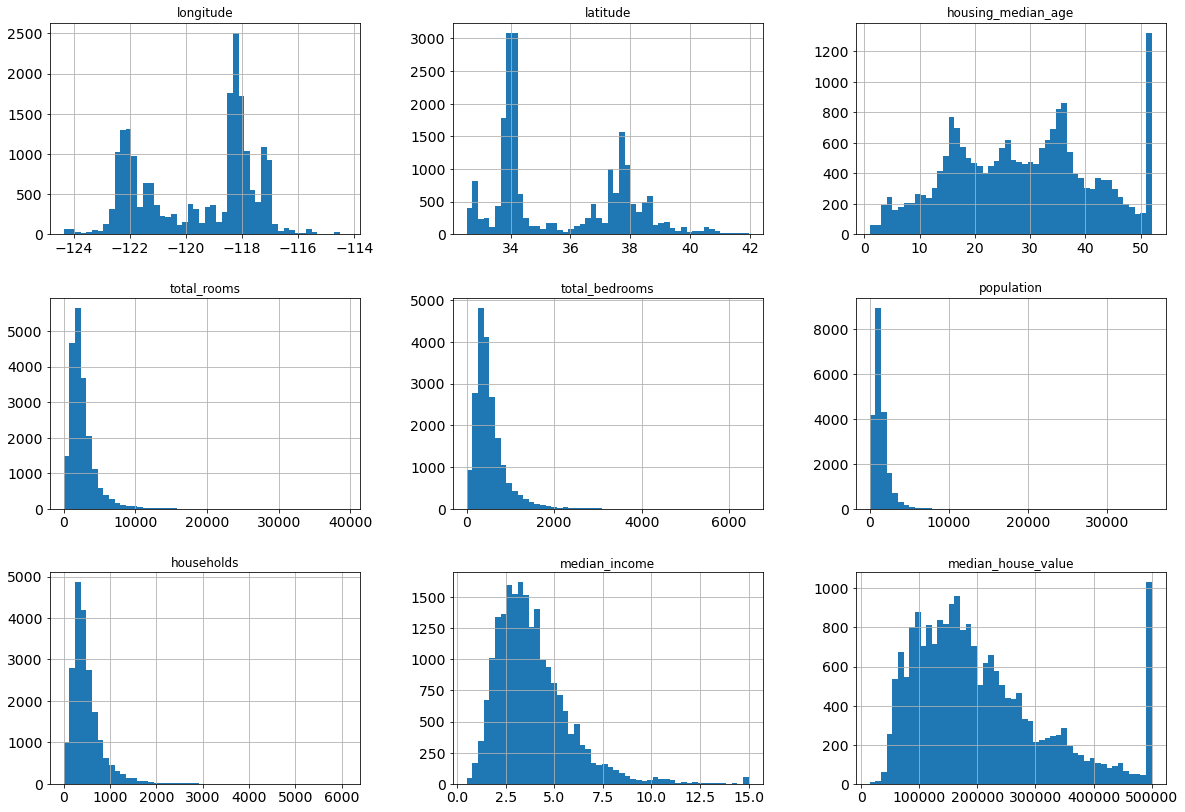

In [16]:
fig = df.hist(bins = 50, figsize = (20,14))
save_graph("attribute_histograms", fig)
plt.show()

In [17]:
px.histogram(strat_train_set['median_income'],nbins=15)

In [18]:
df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [19]:
ocean_df = df['ocean_proximity'].value_counts()
px.histogram(x= ocean_df.index, y = ocean_df)

<a class="anchor" id="4.1"></a>
## Visualizing Geographical Data

Saving matplotlib figure -> bad_visualization_plot


<Figure size 648x432 with 0 Axes>

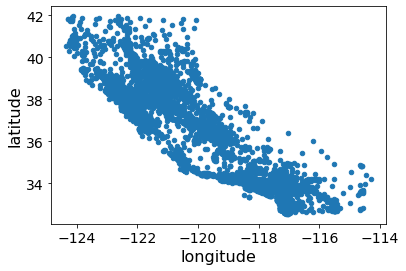

In [20]:
fig = plt.figure(figsize=(9,6))
df.plot(kind="scatter", x="longitude", y="latitude")
save_graph("bad_visualization_plot", fig)
fig.show()

Saving matplotlib figure -> better_visualization_plot


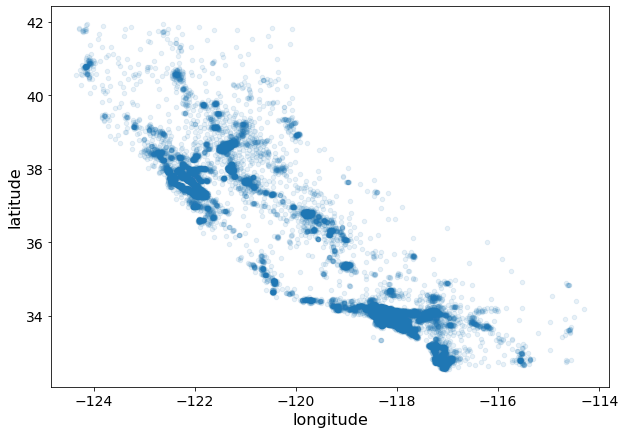

In [21]:
# using Plotly
#fig1=px.scatter(housing, x='longitude', y='latitude', opacity = 0.1)
#fig1.show()
# usong matplotlib
fig2 = df.plot(kind="scatter", x="longitude",
                    y="latitude", alpha = 0.1,
                   figsize = (10,7))
save_graph("better_visualization_plot", fig2)

Saving matplotlib figure -> California housing prices


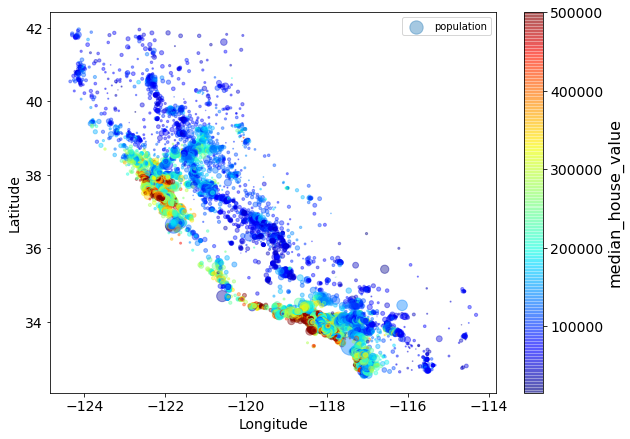

In [22]:
fig3=df.plot(kind = 'scatter',
                  x ='longitude',
                  y ='latitude',
                  c = 'median_house_value',
                  s = df['population']/100, 
                  alpha = 0.4, colorbar = True, label="population",
                  figsize = (10,7), cmap = plt.get_cmap('jet'),
                  sharex = False,
                 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

save_graph('California housing prices',fig3)

In [23]:
# Download the California image
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading {} image...".format(filename))
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, filename);

Saving matplotlib figure -> california_housing_prices_plot


<Figure size 432x288 with 0 Axes>

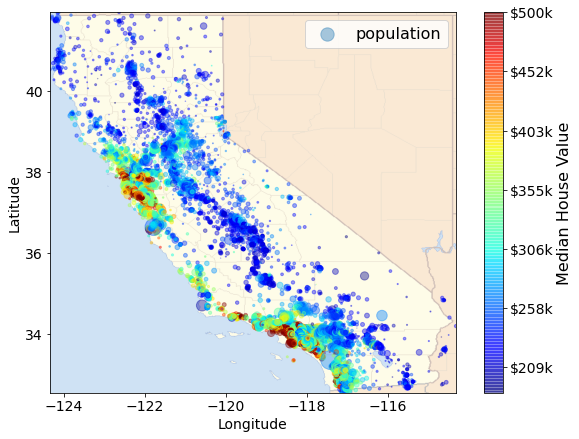

In [24]:
img = mpimg.imread(filename)

fig= plt.figure()
ax = df.plot(kind = 'scatter',
                  x ='longitude',
                  y ='latitude',
                  c = 'median_house_value',
                  s = df['population']/100, 
                  alpha = 0.4, colorbar = False, label="population",
                  figsize = (10,7), cmap = plt.get_cmap('jet'),
                  sharex = False,
                 )

x=df['longitude']
y=df['latitude']

plt.imshow(img,alpha= 0.5, extent=[x.min(), x.max(), y.min(), y.max()], cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df['median_house_value']
bar_ticks = np.linspace(prices.min(),prices.max(), 11)
cbar = plt.colorbar(ticks=bar_ticks/prices.max())
cbar.ax.set_yticklabels(['$%dk'%(round(val/1000)) for val in bar_ticks], fontsize = 14)
cbar.set_label('Median House Value', fontsize=16)
plt.legend(fontsize=16)
save_graph("california_housing_prices_plot",fig)
plt.show()

<a class="anchor" id="4.2"></a>
## Check Correlation

In [25]:
corr_df = df.corr()
x = corr_df["median_house_value"].sort_values(ascending=False)
x.iloc[:][1:]

median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Saving matplotlib figure -> scatter matrix


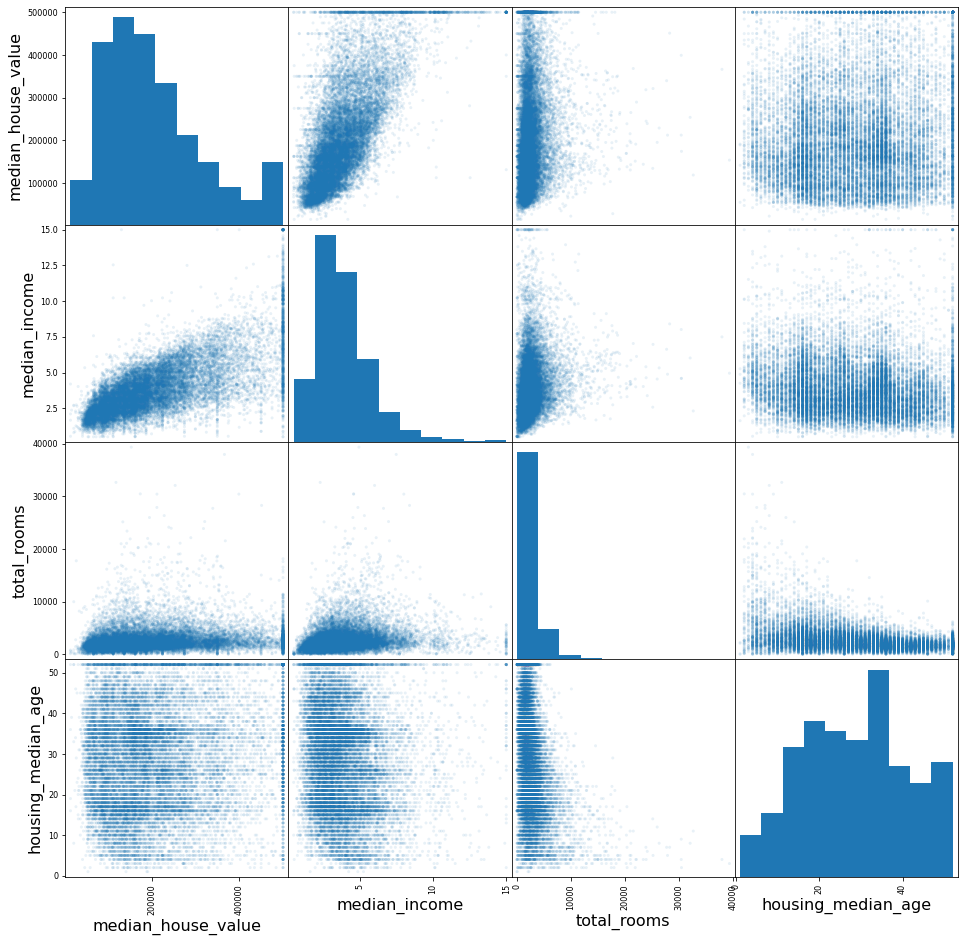

In [26]:
features = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
fig = scatter_matrix(df[features], figsize=(16, 16),alpha = 0.1)
save_graph('scatter matrix',fig)

In [27]:
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"]=df["population"]/df["households"]

In [28]:
corr = df.corr()
corr['median_house_value'].sort_values(ascending= False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

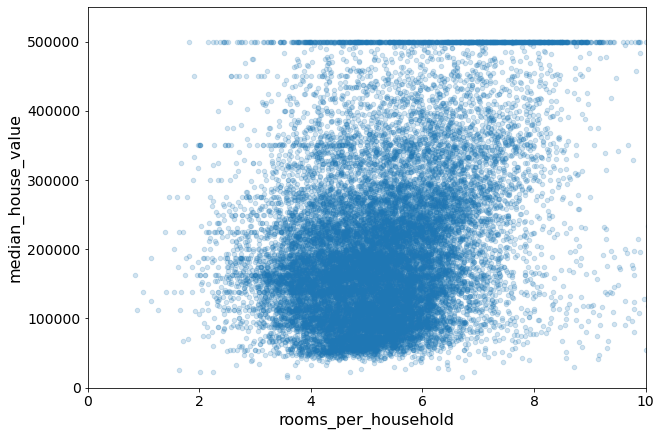

In [29]:
df.plot(kind = 'scatter', x='rooms_per_household',y='median_house_value',
            figsize=(10,7),alpha = 0.2)
plt.axis([0,10,0,550000])
plt.show()

In [30]:
mask = np.triu(np.ones_like(corr, dtype=bool))
df_mask = corr.mask(mask)


hmap = ff.create_annotated_heatmap(z=np.around(df_mask.to_numpy(),2), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdBu,
                                  showscale=True, ygap=1, xgap=1
                                 )

hmap.update_xaxes(side="bottom")

hmap.update_layout(
    title_text='Feature Correlation Heatmap'.upper(), 
    width=1000, 
    height=1000,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed',
    template='plotly_white'
)

for i in range(len(hmap.layout.annotations)):
    hmap.layout.annotations[i].font.size = 8
    hmap.layout.annotations[i].font.color = 'black'
    
    if hmap.layout.annotations[i].text == 'nan':
        hmap.layout.annotations[i].text = ""

hmap.show()

In [31]:
save_graph('corralton matrix',hmap,'plotly')

Saving plotly figure -> corralton matrix


<a class="anchor" id="5.0"></a>
# PREPARING DATA FOR ML ALGORITHMS

In [32]:
y_train = strat_train_set.loc[:,['median_house_value']]
X_train = strat_train_set.drop('median_house_value', axis = 1)
y_test = strat_test_set.loc[:,['median_house_value']]
X_test = strat_test_set.drop('median_house_value', axis = 1)
print('X train shape\t:\t{}'.format(X_train.shape))
print('y train shape\t:\t{}'.format(y_train.shape))
print('X test shape\t:\t{}'.format(X_test.shape))
print('y test shape\t:\t{}'.format(y_test.shape))

X train shape	:	(16512, 9)
y train shape	:	(16512, 1)
X test shape	:	(4128, 9)
y test shape	:	(4128, 1)


In [33]:
cat_train_set = pd.DataFrame(X_train['ocean_proximity'])
num_train_set = X_train.drop(['ocean_proximity'], axis = 1)
num_train_set,cat_train_set

(       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 12655    -121.46     38.52                29.0       3873.0           797.0   
 15502    -117.23     33.09                 7.0       5320.0           855.0   
 2908     -119.04     35.37                44.0       1618.0           310.0   
 14053    -117.13     32.75                24.0       1877.0           519.0   
 20496    -118.70     34.28                27.0       3536.0           646.0   
 ...          ...       ...                 ...          ...             ...   
 15174    -117.07     33.03                14.0       6665.0          1231.0   
 12661    -121.42     38.51                15.0       7901.0          1422.0   
 19263    -122.72     38.44                48.0        707.0           166.0   
 19140    -122.70     38.31                14.0       3155.0           580.0   
 19773    -122.14     39.97                27.0       1079.0           222.0   
 
        population  households  median

In [34]:
num_train_set.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
dtype: int64

<a class="anchor" id="5.1"></a>

## Handling nulls option 1 : drop nulls

In [35]:
training_set1 = num_train_set.copy()
training_set1.shape

(16512, 8)

In [36]:
training_set1 = training_set1.dropna()
training_set1.shape

(16354, 8)

In [37]:
training_set1.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

<a class="anchor" id="5.2"></a>

## Handling nulls option 2 : fill nulls by median

In [38]:
training_set2 = num_train_set.copy()
median = training_set2['total_bedrooms'].median()
training_set2.shape

(16512, 8)

In [39]:
training_set2 = training_set2.fillna(median)
training_set2.shape

(16512, 8)

In [40]:
training_set2.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

<a class="anchor" id="5.3"></a>

## Handling nulls option 3 : fill nulls by median usinf scikit-Learn

In [41]:
'''
    the median can only be computed on numerical attributes, 
    we need to create a copy of the data
    without the text attribute ocean_proximity
'''

imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(num_train_set)
training_set3 = pd.DataFrame(X, columns = num_train_set.columns)

In [42]:
# The imputer has simply computed the median of each attribute and
# stored the result in its statistics_ instance variable
print('Columns medians: \n{}'.format(imputer.statistics_))

Columns medians: 
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [43]:
num_train_set = training_set3.copy()

<a class="anchor" id="5.4"></a>

## Handling Text and Categorical Attributes

In [44]:
encoder1 = OrdinalEncoder()
ord_oceans = encoder1.fit_transform(cat_train_set[['ocean_proximity']])
ord_oceans

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1)

In [45]:
encoder2 = OneHotEncoder()
dummy_oceans = encoder2.fit_transform(cat_train_set[['ocean_proximity']])
dummy_oceans

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [46]:
dummy_oceans.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

<a class="anchor" id="5.5"></a>

## Customized attributes

In [47]:
col_names = ["total_rooms", "total_bedrooms", "population", "households"]
rooms_idx, bedrooms_idx, population_idx, households_idx = [strat_train_set.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room= add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:,rooms_idx] / X[:,households_idx]
        population_per_household = X[:,population_idx] / X[:,households_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_idx] / X[:, rooms_idx]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]       

In [48]:
combined_est = CombinedAttributesAdder(add_bedrooms_per_room = False)
combined_attrs = combined_est.transform(num_train_set.values)
num_train_df = pd.DataFrame(combined_attrs,
                              columns=list(num_train_set.columns)+["rooms_per_household", "population_per_household"],
                              index = num_train_set.index)

num_train_df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'population_per_household'],
      dtype='object')

<a class="anchor" id="6.0"></a>

# Create Pipline

In [49]:
mum_pipline = Pipeline([
    ('imputer',SimpleImputer(strategy = 'median')),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_sacler',StandardScaler()),
    
])

num_train_tmp = mum_pipline.fit_transform(num_train_set)
num_train_tmp

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [50]:
list(num_train_set.columns)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [51]:
# Preprocessing pipeline that takes the full housing data 
# and applies the appropriate transformations to each column.

numerical_attr= list(num_train_set.columns)
categorical_attr = list(cat_train_set.columns)

full_pipeline=ColumnTransformer([
    ('NumericalSet',mum_pipline, numerical_attr),
    ('CategoricalSet',OneHotEncoder(), categorical_attr)
])

prepared_data = full_pipeline.fit_transform(X_train)

In [52]:
print("prepared data has {} instances with {} attributes".format(len(prepared_data),prepared_data.shape[1]))

prepared data has 16512 instances with 16 attributes


<a class="anchor" id="7.0"></a>

# TRAINING AND EVALUATING 

<a class="anchor" id="7.1"></a>
## Linear Regression Model

In [53]:
reg_model = LinearRegression()
reg_model.fit(prepared_data,y_train)

LinearRegression()

In [54]:
# evaluate it on the training set
y_pred = reg_model.predict(prepared_data)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print('Root Mean Square Error: {:6,.2f} $'.format(rmse))

Root Mean Square Error: 68,637.14 $


>A typical prediction error of 68,637.14$ is not very satisfying. This is an example of a model underfitting the training data

<a class="anchor" id="7.2"></a>
## Dession Tree Model

In [55]:
DT_model = DecisionTreeRegressor()
DT_model.fit(prepared_data,y_train)

DecisionTreeRegressor()

In [56]:
# Evaluate Desion tree using traning set
y_pred = DT_model.predict(prepared_data)
y_pred[:5]

array([ 72100., 279600.,  82700., 112500., 238300.])

In [57]:
y_train[:5].values

array([[ 72100.],
       [279600.],
       [ 82700.],
       [112500.],
       [238300.]])

In [58]:
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
print('RMSE: {:6,.2f}$'.format(rmse))

RMSE:   0.00$


> No error at all?! it is much more likely that the model has badly overfit the data.I don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training, and part for model validation.

<a class="anchor" id="7.3"></a>
## Random Forest Model

In [59]:
RF_model = RandomForestRegressor()
RF_model.fit(prepared_data, y_train)

RandomForestRegressor()

In [60]:
# evaluate random forest on the training
y_pred = RF_model.predict(prepared_data)
RF_rmse = np.sqrt(mean_squared_error(y_train,y_pred))
print('RMSE: {:6,.2f}$'.format(RF_rmse))

RMSE: 18,762.48$


<a class="anchor" id="7.4"></a>
## Suport Vector Machine Model

In [61]:
svm_model = SVR(kernel="linear")
svm_model.fit(prepared_data, y_train)

SVR(kernel='linear')

In [62]:
y_pred = svm_model.predict(prepared_data)
svm_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print('RMSE: {:6,.2f}$'.format(svm_rmse))

RMSE: 111,095.07$


<a class="anchor" id="8.0"></a>

# FINE TUNING

<a class="anchor" id="8.1"></a>
## Evaluate models Cross-Validation

In [63]:
# evaluate it on the training set using k-folds
cv = 1000
start_time = time.time()
LR_sc = cross_val_score(reg_model, prepared_data, y_train, scoring="neg_mean_squared_error",cv=cv)
print('It takes {:2.2f} sec to train the model using {} cv'.format(time.time()-start_time,cv))

It takes 10.46 sec to train the model using 1000 cv


In [65]:
LR_rmse = np.sqrt(-LR_sc)
print('RMSE of {} for [{}] cv is: {:6,.2f}$'.format(reg_model,cv,LR_rmse.mean()))

RMSE of LinearRegression() for [1000] cv is: 66,105.64$


In [66]:
# evaluate it on the training set using k-folds
cv = 50
start_time = time.time()
DT_sc = cross_val_score(DT_model, prepared_data, y_train, scoring="neg_mean_squared_error",cv=cv)
print('It takes {:2.2f} sec to train the model using {} cv'.format(time.time()-start_time,cv))

It takes 9.82 sec to train the model using 50 cv


In [67]:
DT_rmse = np.sqrt(-DT_sc)
print('RMSE of {} for [{}] cv is:  {:6,.2f}$'.format(DT_model,cv,DT_rmse.mean()))

RMSE of DecisionTreeRegressor() for [50] cv is:  71,101.80$


> The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

In [68]:
start_time = time.time()
cv=10
RF_sc = cross_val_score(RF_model, prepared_data, y_train, scoring="neg_mean_squared_error",cv=cv)
print('It takes {:2.2f} sec to train the model using {} cv'.format(time.time()-start_time,cv))

It takes 106.07 sec to train the model using 10 cv


In [69]:
RF_rmse=np.sqrt(-RF_sc)
print('RMSE of {} for [{}] cv is:  {:6,.2f}$'.format(RF_model,cv,RF_rmse.mean()))

RMSE of RandomForestRegressor() for [10] cv is:  50,205.36$


> Random Forests look very promising. However,the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set.

<a class="anchor" id="8.2"></a>
## Grid Search

In [70]:
param_grid=[
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}
]

RF_reg = RandomForestRegressor()
grid_search=GridSearchCV(RF_reg,param_grid,cv=5,verbose=2,
                      scoring='neg_mean_squared_error',
                     return_train_score = True)
grid_search.fit(prepared_data, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .....................max_features=2, n_estimators=3; total time=   0.0s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.0s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.0s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.0s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.0s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.1s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.1s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.1s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.1s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.1s
[CV] END ....................max_features=2, n_estimators=30; total time=   0.4s
[CV] END ....................max_features=2, n_e

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [71]:
results = grid_search.cv_results_
print('Training Score\t Testing Score\t Parameters')
for m_train,m_test,params in zip(results['mean_train_score'],results['mean_test_score'],results['params']):
    print(np.round(np.sqrt(-m_train),2),'\t',np.round(np.sqrt(-m_test),2),'\t',params)

Training Score	 Testing Score	 Parameters
33648.0 	 64875.8 	 {'max_features': 2, 'n_estimators': 3}
23968.76 	 55103.1 	 {'max_features': 2, 'n_estimators': 10}
20785.75 	 52609.01 	 {'max_features': 2, 'n_estimators': 30}
30985.78 	 60069.58 	 {'max_features': 4, 'n_estimators': 3}
22909.05 	 52634.36 	 {'max_features': 4, 'n_estimators': 10}
19834.78 	 50225.1 	 {'max_features': 4, 'n_estimators': 30}
30297.67 	 59031.16 	 {'max_features': 6, 'n_estimators': 3}
22286.05 	 52164.4 	 {'max_features': 6, 'n_estimators': 10}
19463.68 	 49846.2 	 {'max_features': 6, 'n_estimators': 30}
30148.49 	 58988.56 	 {'max_features': 8, 'n_estimators': 3}
22212.4 	 51905.05 	 {'max_features': 8, 'n_estimators': 10}
19569.39 	 50115.29 	 {'max_features': 8, 'n_estimators': 30}
14.67 	 61552.4 	 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.44 	 54200.74 	 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
3.12 	 60562.54 	 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [73]:
print('Best Estimator: ',grid_search.best_estimator_)

Best Estimator:  RandomForestRegressor(max_features=6, n_estimators=30)


<a class="anchor" id="8.3"></a>
## Random Search

In [74]:
params = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }
cv=5
iters=10

RF_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(RF_model,param_distributions =params,random_state=42,
                                 n_iter=iters, cv=cv,scoring='neg_mean_squared_error')
random_search.fit(prepared_data, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017BE181B940>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017BE15DBA30>},
                   random_state=42, scoring='neg_mean_squared_error')

In [75]:
results = random_search.cv_results_
print('Testing Score\t Parameters')
for m_test,params in zip(results['mean_test_score'],results['params']):
    print('{:,f}\t{}'.format(np.sqrt(-m_test),params))

Testing Score	 Parameters
49,117.553443	{'max_features': 7, 'n_estimators': 180}
51,450.632029	{'max_features': 5, 'n_estimators': 15}
50,692.535882	{'max_features': 3, 'n_estimators': 72}
50,783.614494	{'max_features': 5, 'n_estimators': 21}
49,162.898775	{'max_features': 7, 'n_estimators': 122}
50,655.798471	{'max_features': 3, 'n_estimators': 75}
50,513.856320	{'max_features': 3, 'n_estimators': 88}
49,521.172020	{'max_features': 5, 'n_estimators': 100}
50,302.904408	{'max_features': 3, 'n_estimators': 150}
65,167.020186	{'max_features': 5, 'n_estimators': 2}


In [76]:
print('Best Estimator: ',random_search.best_estimator_)

Best Estimator:  RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)


<a class="anchor" id="8.4"></a>
## Analyze the Best Models and Their Errors

In [77]:
feature_importances = np.round(grid_search.best_estimator_.feature_importances_,4)
feature_importances

array([0.0697, 0.0675, 0.0429, 0.0188, 0.0167, 0.0175, 0.0162, 0.3186,
       0.0586, 0.1151, 0.0746, 0.0067, 0.1707, 0.    , 0.0021, 0.0042])

In [78]:
num_attrs = list(num_train_set.columns)
created_attrs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_['CategoricalSet']
cat_attrs = list(cat_encoder.categories_[0])
all_attrs = num_attrs + created_attrs + cat_attrs
all_attrs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [79]:
sorted(zip(feature_importances, all_attrs), reverse = True)

[(0.3186, 'median_income'),
 (0.1707, 'INLAND'),
 (0.1151, 'pop_per_hhold'),
 (0.0746, 'bedrooms_per_room'),
 (0.0697, 'longitude'),
 (0.0675, 'latitude'),
 (0.0586, 'rooms_per_hhold'),
 (0.0429, 'housing_median_age'),
 (0.0188, 'total_rooms'),
 (0.0175, 'population'),
 (0.0167, 'total_bedrooms'),
 (0.0162, 'households'),
 (0.0067, '<1H OCEAN'),
 (0.0042, 'NEAR OCEAN'),
 (0.0021, 'NEAR BAY'),
 (0.0, 'ISLAND')]

<a class="anchor" id="9.0"></a>

# TESTING BEST MODEL

In [80]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set['median_house_value']

X_test_prepared = full_pipeline.transform(X_test)

In [81]:
y_preds = final_model.predict(X_test_prepared)
print('Prediction values : ',list(np.round(y_preds[:10],2)))
print('Actual values\t:   ',list(y_test[:10]))

Prediction values :  [474377.23, 244720.03, 211386.67, 166206.67, 251920.0, 159593.33, 127323.37, 419880.2, 238750.0, 255813.37]
Actual values	:    [500001.0, 162500.0, 204600.0, 159700.0, 184000.0, 151900.0, 104900.0, 500001.0, 367400.0, 346500.0]


In [82]:
best_model_rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('RMSE: {:6,.2f}$'.format(best_model_rmse))

RMSE: 48,479.33$


In [83]:
confidence = 0.95
squared_errors = (y_preds - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46523.10695127, 50359.61888545])

<a class="anchor" id="10.0"></a>

# FINAL PIPLINE WITH TESTING

In [84]:
full_pipeline_with_estimator = Pipeline([
        ("preparation", full_pipeline),
        ("linear", RandomForestRegressor())
    ])

full_pipeline_with_estimator.fit(X_train, y_train)
y_preds = full_pipeline_with_estimator.predict(X_test)

In [85]:
print('Prediction values : ',list(np.round(y_preds[:10],2)))
print('Actual values\t:   ',list(y_test[:10]))
best_model_rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('RMSE: {:6,.2f}$'.format(best_model_rmse))

Prediction values :  [490149.85, 225712.03, 214206.0, 166142.0, 261910.01, 161073.0, 113634.0, 412596.17, 228043.02, 313987.14]
Actual values	:    [500001.0, 162500.0, 204600.0, 159700.0, 184000.0, 151900.0, 104900.0, 500001.0, 367400.0, 346500.0]
RMSE: 48,442.60$
